# 31. 基于MindSpore实现目标检测示例

本节通过Mindspore的API实现目标检测，使用本地数据集

## 1、实验目的

- 学会待处理图像的数据载入及处理。
- 了解SSD网络原理并掌握搭建SSD网络模型。
- 掌握目标检测任务的训练流程。

## 2、 目标检测原理介绍

SSD（Single Shot MultiBox Detector） 是 Google 在 2016 年提出的一种 单阶段目标检测模型，其目标是在保持高准确率的同时，实现更快的推理速度
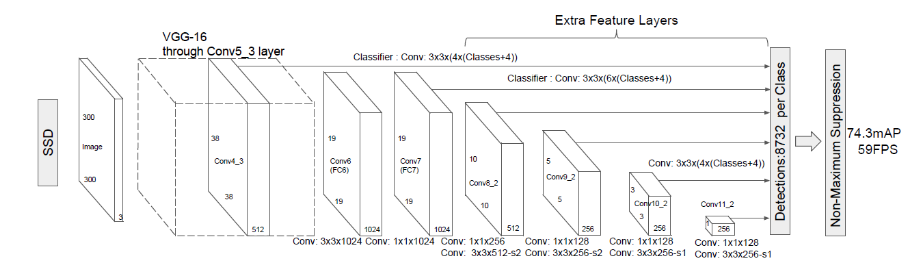
SSD 模型首先使用一个主干网络（如 VGG16 或 MobileNet）提取图像的基础特征，然后在主干网络的多个层级上附加额外的卷积层，形成一组分辨率逐渐降低的特征图，用于多尺度目标检测。每个特征图的每个位置会生成多个不同尺度和长宽比的默认框（Default Boxes），并对每个框进行类别预测和边界框回归，从而实现一次前向传播内同时完成目标定位与分类，最终通过非极大值抑制（NMS）得到检测结果。



## 3、 实验环境

在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.4.10；Python环境=3.11。


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.4.10 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU |Linux-x86_64| MindSpore2.4.10 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.4.10 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、实验处理

### 4.1 数据准备

数据集采用coco2017,训练集包含50张图片，验证集包含10张图片

In [1]:
from download import download

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/ssd_datasets.zip"
path = "./"
path = download(dataset_url, path, kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 16.8M/16.8M [00:01<00:00, 10.2MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


##### 为数据定义输入

In [2]:
coco_root = "./datasets/"
anno_json = "./datasets/annotations/instances_val2017.json"

train_cls = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
             'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
             'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
             'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
             'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
             'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
             'kite', 'baseball bat', 'baseball glove', 'skateboard',
             'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
             'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
             'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
             'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
             'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
             'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
             'refrigerator', 'book', 'clock', 'vase', 'scissors',
             'teddy bear', 'hair drier', 'toothbrush']

train_cls_dict = {}
for i, cls in enumerate(train_cls):
    train_cls_dict[cls] = i


### 4.2 数据采样

为了使模型对于各种输入对象大小和形状更加鲁棒，SSD算法每个训练图像通过以下选项之一随机采样：

使用整个原始输入图像

采样一个区域，使采样区域和原始图片最小的交并比重叠为0.1,0.3,0.5,0.7或0.9

随机采样一个区域

每个采样区域的大小为原始图像大小的[0.3,1]，长宽比在1/2和2之间。如果真实标签框中心在采样区域内，则保留两者重叠部分作为新图片的真实标注框。在上述采样步骤之后，将每个采样区域大小调整为固定大小，并以0.5的概率水平翻转

In [3]:
import cv2
import numpy as np

def _rand(a=0., b=1.):
    return np.random.rand() * (b - a) + a

def intersect(box_a, box_b):
    """Compute the intersect of two sets of boxes."""
    max_yx = np.minimum(box_a[:, 2:4], box_b[2:4])
    min_yx = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_yx - min_yx), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]

def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes."""
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2] - box_a[:, 0]) *
              (box_a[:, 3] - box_a[:, 1]))
    area_b = ((box_b[2] - box_b[0]) *
              (box_b[3] - box_b[1]))
    union = area_a + area_b - inter
    return inter / union

def random_sample_crop(image, boxes):
    """Crop images and boxes randomly."""
    height, width, _ = image.shape
    min_iou = np.random.choice([None, 0.1, 0.3, 0.5, 0.7, 0.9])

    if min_iou is None:
        return image, boxes

    for _ in range(50):
        image_t = image
        w = _rand(0.3, 1.0) * width
        h = _rand(0.3, 1.0) * height
        # aspect ratio constraint b/t .5 & 2
        if h / w < 0.5 or h / w > 2:
            continue

        left = _rand() * (width - w)
        top = _rand() * (height - h)
        rect = np.array([int(top), int(left), int(top + h), int(left + w)])
        overlap = jaccard_numpy(boxes, rect)

        # dropout some boxes
        drop_mask = overlap > 0
        if not drop_mask.any():
            continue

        if overlap[drop_mask].min() < min_iou and overlap[drop_mask].max() > (min_iou + 0.2):
            continue

        image_t = image_t[rect[0]:rect[2], rect[1]:rect[3], :]
        centers = (boxes[:, :2] + boxes[:, 2:4]) / 2.0
        m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])
        m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

        # mask in that both m1 and m2 are true
        mask = m1 * m2 * drop_mask

        # have any valid boxes? try again if not
        if not mask.any():
            continue

        # take only matching gt boxes
        boxes_t = boxes[mask, :].copy()
        boxes_t[:, :2] = np.maximum(boxes_t[:, :2], rect[:2])
        boxes_t[:, :2] -= rect[:2]
        boxes_t[:, 2:4] = np.minimum(boxes_t[:, 2:4], rect[2:4])
        boxes_t[:, 2:4] -= rect[:2]

        return image_t, boxes_t
    return image, boxes

def ssd_bboxes_encode(boxes):
    """Labels anchors with ground truth inputs."""

    def jaccard_with_anchors(bbox):
        """Compute jaccard score a box and the anchors."""
        # Intersection bbox and volume.
        ymin = np.maximum(y1, bbox[0])
        xmin = np.maximum(x1, bbox[1])
        ymax = np.minimum(y2, bbox[2])
        xmax = np.minimum(x2, bbox[3])
        w = np.maximum(xmax - xmin, 0.)
        h = np.maximum(ymax - ymin, 0.)

        # Volumes.
        inter_vol = h * w
        union_vol = vol_anchors + (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) - inter_vol
        jaccard = inter_vol / union_vol
        return np.squeeze(jaccard)

    pre_scores = np.zeros((8732), dtype=np.float32)
    t_boxes = np.zeros((8732, 4), dtype=np.float32)
    t_label = np.zeros((8732), dtype=np.int64)
    for bbox in boxes:
        label = int(bbox[4])
        scores = jaccard_with_anchors(bbox)
        idx = np.argmax(scores)
        scores[idx] = 2.0
        mask = (scores > matching_threshold)
        mask = mask & (scores > pre_scores)
        pre_scores = np.maximum(pre_scores, scores * mask)
        t_label = mask * label + (1 - mask) * t_label
        for i in range(4):
            t_boxes[:, i] = mask * bbox[i] + (1 - mask) * t_boxes[:, i]

    index = np.nonzero(t_label)

    # Transform to tlbr.
    bboxes = np.zeros((8732, 4), dtype=np.float32)
    bboxes[:, [0, 1]] = (t_boxes[:, [0, 1]] + t_boxes[:, [2, 3]]) / 2
    bboxes[:, [2, 3]] = t_boxes[:, [2, 3]] - t_boxes[:, [0, 1]]

    # Encode features.
    bboxes_t = bboxes[index]
    default_boxes_t = default_boxes[index]
    bboxes_t[:, :2] = (bboxes_t[:, :2] - default_boxes_t[:, :2]) / (default_boxes_t[:, 2:] * 0.1)
    tmp = np.maximum(bboxes_t[:, 2:4] / default_boxes_t[:, 2:4], 0.000001)
    bboxes_t[:, 2:4] = np.log(tmp) / 0.2
    bboxes[index] = bboxes_t

    num_match = np.array([len(np.nonzero(t_label)[0])], dtype=np.int32)
    return bboxes, t_label.astype(np.int32), num_match

def preprocess_fn(img_id, image, box, is_training):
    """Preprocess function for dataset."""
    cv2.setNumThreads(2)

    def _infer_data(image, input_shape):
        img_h, img_w, _ = image.shape
        input_h, input_w = input_shape

        image = cv2.resize(image, (input_w, input_h))

        # When the channels of image is 1
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
            image = np.concatenate([image, image, image], axis=-1)

        return img_id, image, np.array((img_h, img_w), np.float32)

    def _data_aug(image, box, is_training, image_size=(300, 300)):
        ih, iw, _ = image.shape
        h, w = image_size
        if not is_training:
            return _infer_data(image, image_size)
        # Random crop
        box = box.astype(np.float32)
        image, box = random_sample_crop(image, box)
        ih, iw, _ = image.shape
        # Resize image
        image = cv2.resize(image, (w, h))
        # Flip image or not
        flip = _rand() < .5
        if flip:
            image = cv2.flip(image, 1, dst=None)
        # When the channels of image is 1
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
            image = np.concatenate([image, image, image], axis=-1)
        box[:, [0, 2]] = box[:, [0, 2]] / ih
        box[:, [1, 3]] = box[:, [1, 3]] / iw
        if flip:
            box[:, [1, 3]] = 1 - box[:, [3, 1]]
        box, label, num_match = ssd_bboxes_encode(box)
        return image, box, label, num_match

    return _data_aug(image, box, is_training, image_size=[300, 300])


###  4.3 数据集创建

In [4]:
from mindspore import Tensor
from mindspore.dataset import MindDataset
from mindspore.dataset.vision import Decode, HWC2CHW, Normalize, RandomColorAdjust


def create_ssd_dataset(mindrecord_file, batch_size=32, device_num=1, rank=0,
                       is_training=True, num_parallel_workers=1, use_multiprocessing=True):
    """Create SSD dataset with MindDataset."""
    dataset = MindDataset(mindrecord_file, columns_list=["img_id", "image", "annotation"], num_shards=device_num,
                          shard_id=rank, num_parallel_workers=num_parallel_workers, shuffle=is_training)

    decode = Decode()
    dataset = dataset.map(operations=decode, input_columns=["image"])

    change_swap_op = HWC2CHW()
    # Computed from random subset of ImageNet training images
    normalize_op = Normalize(mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                             std=[0.229 * 255, 0.224 * 255, 0.225 * 255])
    color_adjust_op = RandomColorAdjust(brightness=0.4, contrast=0.4, saturation=0.4)
    compose_map_func = (lambda img_id, image, annotation: preprocess_fn(img_id, image, annotation, is_training))

    if is_training:
        output_columns = ["image", "box", "label", "num_match"]
        trans = [color_adjust_op, normalize_op, change_swap_op]
    else:
        output_columns = ["img_id", "image", "image_shape"]
        trans = [normalize_op, change_swap_op]

    dataset = dataset.map(operations=compose_map_func, input_columns=["img_id", "image", "annotation"],
                          output_columns=output_columns, python_multiprocessing=use_multiprocessing,
                          num_parallel_workers=num_parallel_workers)

    dataset = dataset.map(operations=trans, input_columns=["image"], python_multiprocessing=use_multiprocessing,
                          num_parallel_workers=num_parallel_workers)

    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


## 5、模型构建

### 定义网络

In [5]:
from mindspore import nn

def _make_layer(channels):
    in_channels = channels[0]
    layers = []
    for out_channels in channels[1:]:
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3))
        layers.append(nn.ReLU())
        in_channels = out_channels
    return nn.SequentialCell(layers)

class Vgg16(nn.Cell):
    """VGG16 module."""

    def __init__(self):
        super(Vgg16, self).__init__()
        self.b1 = _make_layer([3, 64, 64])
        self.b2 = _make_layer([64, 128, 128])
        self.b3 = _make_layer([128, 256, 256, 256])
        self.b4 = _make_layer([256, 512, 512, 512])
        self.b5 = _make_layer([512, 512, 512, 512])

        self.m1 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='SAME')
        self.m2 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='SAME')
        self.m3 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='SAME')
        self.m4 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='SAME')
        self.m5 = nn.MaxPool2d(kernel_size=3, stride=1, pad_mode='SAME')

    def construct(self, x):
        # block1
        x = self.b1(x)
        x = self.m1(x)

        # block2
        x = self.b2(x)
        x = self.m2(x)

        # block3
        x = self.b3(x)
        x = self.m3(x)

        # block4
        x = self.b4(x)
        block4 = x
        x = self.m4(x)

        # block5
        x = self.b5(x)
        x = self.m5(x)

        return block4, x


In [6]:
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops

def _last_conv2d(in_channel, out_channel, kernel_size=3, stride=1, pad_mod='same', pad=0):
    in_channels = in_channel
    out_channels = in_channel
    depthwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='same',
                               padding=pad, group=in_channels)
    conv = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0, pad_mode='same', has_bias=True)
    bn = nn.BatchNorm2d(in_channel, eps=1e-3, momentum=0.97,
                        gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

    return nn.SequentialCell([depthwise_conv, bn, nn.ReLU6(), conv])

class FlattenConcat(nn.Cell):
    """FlattenConcat module."""

    def __init__(self):
        super(FlattenConcat, self).__init__()
        self.num_ssd_boxes = 8732

    def construct(self, inputs):
        output = ()
        batch_size = ops.shape(inputs[0])[0]
        for x in inputs:
            x = ops.transpose(x, (0, 2, 3, 1))
            output += (ops.reshape(x, (batch_size, -1)),)
        res = ops.concat(output, axis=1)
        return ops.reshape(res, (batch_size, self.num_ssd_boxes, -1))

class MultiBox(nn.Cell):
    """
    Multibox conv layers. Each multibox layer contains class conf scores and localization predictions.
    """

    def __init__(self):
        super(MultiBox, self).__init__()
        num_classes = 81
        out_channels = [512, 1024, 512, 256, 256, 256]
        num_default = [4, 6, 6, 6, 4, 4]

        loc_layers = []
        cls_layers = []
        for k, out_channel in enumerate(out_channels):
            loc_layers += [_last_conv2d(out_channel, 4 * num_default[k],
                                        kernel_size=3, stride=1, pad_mod='same', pad=0)]
            cls_layers += [_last_conv2d(out_channel, num_classes * num_default[k],
                                        kernel_size=3, stride=1, pad_mod='same', pad=0)]

        self.multi_loc_layers = nn.CellList(loc_layers)
        self.multi_cls_layers = nn.CellList(cls_layers)
        self.flatten_concat = FlattenConcat()

    def construct(self, inputs):
        loc_outputs = ()
        cls_outputs = ()
        for i in range(len(self.multi_loc_layers)):
            loc_outputs += (self.multi_loc_layers[i](inputs[i]),)
            cls_outputs += (self.multi_cls_layers[i](inputs[i]),)
        return self.flatten_concat(loc_outputs), self.flatten_concat(cls_outputs)

class SSD300Vgg16(nn.Cell):
    """SSD300Vgg16 module."""

    def __init__(self):
        super(SSD300Vgg16, self).__init__()

        # VGG16 backbone: block1~5
        self.backbone = Vgg16()

        # SSD blocks: block6~7
        self.b6_1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=6, dilation=6, pad_mode='pad')
        self.b6_2 = nn.Dropout(p=0.5)

        self.b7_1 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1)
        self.b7_2 = nn.Dropout(p=0.5)

        # Extra Feature Layers: block8~11
        self.b8_1 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, padding=1, pad_mode='pad')
        self.b8_2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, pad_mode='valid')

        self.b9_1 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, padding=1, pad_mode='pad')
        self.b9_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, pad_mode='valid')

        self.b10_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)
        self.b10_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, pad_mode='valid')

        self.b11_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)
        self.b11_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, pad_mode='valid')

        # boxes
        self.multi_box = MultiBox()

    def construct(self, x):
        # VGG16 backbone: block1~5
        block4, x = self.backbone(x)

        # SSD blocks: block6~7
        x = self.b6_1(x)  # 1024
        x = self.b6_2(x)

        x = self.b7_1(x)  # 1024
        x = self.b7_2(x)
        block7 = x

        # Extra Feature Layers: block8~11
        x = self.b8_1(x)  # 256
        x = self.b8_2(x)  # 512
        block8 = x

        x = self.b9_1(x)  # 128
        x = self.b9_2(x)  # 256
        block9 = x

        x = self.b10_1(x)  # 128
        x = self.b10_2(x)  # 256
        block10 = x

        x = self.b11_1(x)  # 128
        x = self.b11_2(x)  # 256
        block11 = x

        # boxes
        multi_feature = (block4, block7, block8, block9, block10, block11)
        pred_loc, pred_label = self.multi_box(multi_feature)
        if not self.training:
            pred_label = ops.sigmoid(pred_label)
        pred_loc = pred_loc.astype(ms.float32)
        pred_label = pred_label.astype(ms.float32)
        return pred_loc, pred_label


###  损失函数

In [7]:
def class_loss(logits, label):
    """Calculate category losses."""
    label = ops.one_hot(label, ops.shape(logits)[-1], Tensor(1.0, ms.float32), Tensor(0.0, ms.float32))
    weight = ops.ones_like(logits)
    pos_weight = ops.ones_like(logits)
    sigmiod_cross_entropy = ops.binary_cross_entropy_with_logits(logits, label, weight.astype(ms.float32), pos_weight.astype(ms.float32))
    sigmoid = ops.sigmoid(logits)
    label = label.astype(ms.float32)
    p_t = label * sigmoid + (1 - label) * (1 - sigmoid)
    modulating_factor = ops.pow(1 - p_t, 2.0)
    alpha_weight_factor = label * 0.75 + (1 - label) * (1 - 0.75)
    focal_loss = modulating_factor * alpha_weight_factor * sigmiod_cross_entropy
    return focal_loss


###  评价指标

在SSD中，训练过程是不需要用到非极大值抑制(NMS)，但当进行检测时，例如输入一张图片要求输出框的时候，需要用到NMS过滤掉那些重叠度较大的预测框。 非极大值抑制的流程如下：

1、根据置信度得分进行排序

2、选择置信度最高的比边界框添加到最终输出列表中，将其从边界框列表中删除

3、计算所有边界框的面积

4、计算置信度最高的边界框与其他候选框的IoU

5、删除IoU大于阈值的边界框

6、重复上述过程，直至边界框列表为空

In [8]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


def apply_eval(eval_param_dict):
    net = eval_param_dict["net"]
    net.set_train(False)
    ds = eval_param_dict["dataset"]
    anno_json = eval_param_dict["anno_json"]
    coco_metrics = COCOMetrics(anno_json=anno_json,
                               classes=train_cls,
                               num_classes=81,
                               max_boxes=100,
                               nms_threshold=0.6,
                               min_score=0.1)
    for data in ds.create_dict_iterator(output_numpy=True, num_epochs=1):
        img_id = data['img_id']
        img_np = data['image']
        image_shape = data['image_shape']

        output = net(Tensor(img_np))

        for batch_idx in range(img_np.shape[0]):
            pred_batch = {
                "boxes": output[0].asnumpy()[batch_idx],
                "box_scores": output[1].asnumpy()[batch_idx],
                "img_id": int(np.squeeze(img_id[batch_idx])),
                "image_shape": image_shape[batch_idx]
            }
            coco_metrics.update(pred_batch)
    eval_metrics = coco_metrics.get_metrics()
    return eval_metrics


def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    y1 = all_boxes[:, 0]
    x1 = all_boxes[:, 1]
    y2 = all_boxes[:, 2]
    x2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep


class COCOMetrics:
    """Calculate mAP of predicted bboxes."""

    def __init__(self, anno_json, classes, num_classes, min_score, nms_threshold, max_boxes):
        self.num_classes = num_classes
        self.classes = classes
        self.min_score = min_score
        self.nms_threshold = nms_threshold
        self.max_boxes = max_boxes

        self.val_cls_dict = {i: cls for i, cls in enumerate(classes)}
        self.coco_gt = COCO(anno_json)
        cat_ids = self.coco_gt.loadCats(self.coco_gt.getCatIds())
        self.class_dict = {cat['name']: cat['id'] for cat in cat_ids}

        self.predictions = []
        self.img_ids = []

    def update(self, batch):
        pred_boxes = batch['boxes']
        box_scores = batch['box_scores']
        img_id = batch['img_id']
        h, w = batch['image_shape']

        final_boxes = []
        final_label = []
        final_score = []
        self.img_ids.append(img_id)

        for c in range(1, self.num_classes):
            class_box_scores = box_scores[:, c]
            score_mask = class_box_scores > self.min_score
            class_box_scores = class_box_scores[score_mask]
            class_boxes = pred_boxes[score_mask] * [h, w, h, w]

            if score_mask.any():
                nms_index = apply_nms(class_boxes, class_box_scores, self.nms_threshold, self.max_boxes)
                class_boxes = class_boxes[nms_index]
                class_box_scores = class_box_scores[nms_index]

                final_boxes += class_boxes.tolist()
                final_score += class_box_scores.tolist()
                final_label += [self.class_dict[self.val_cls_dict[c]]] * len(class_box_scores)

        for loc, label, score in zip(final_boxes, final_label, final_score):
            res = {}
            res['image_id'] = img_id
            res['bbox'] = [loc[1], loc[0], loc[3] - loc[1], loc[2] - loc[0]]
            res['score'] = score
            res['category_id'] = label
            self.predictions.append(res)

    def get_metrics(self):
        with open('predictions.json', 'w') as f:
            json.dump(self.predictions, f)

        coco_dt = self.coco_gt.loadRes('predictions.json')
        E = COCOeval(self.coco_gt, coco_dt, iouType='bbox')
        E.params.imgIds = self.img_ids
        E.evaluate()
        E.accumulate()
        E.summarize()
        return E.stats[0]


class SsdInferWithDecoder(nn.Cell):
    """
SSD Infer wrapper to decode the bbox locations."""

    def __init__(self, network, default_boxes, ckpt_path):
        super(SsdInferWithDecoder, self).__init__()
        param_dict = ms.load_checkpoint(ckpt_path)
        ms.load_param_into_net(network, param_dict)
        self.network = network
        self.default_boxes = default_boxes
        self.prior_scaling_xy = 0.1
        self.prior_scaling_wh = 0.2

    def construct(self, x):
        pred_loc, pred_label = self.network(x)

        default_bbox_xy = self.default_boxes[..., :2]
        default_bbox_wh = self.default_boxes[..., 2:]
        pred_xy = pred_loc[..., :2] * self.prior_scaling_xy * default_bbox_wh + default_bbox_xy
        pred_wh = ops.exp(pred_loc[..., 2:] * self.prior_scaling_wh) * default_bbox_wh

        pred_xy_0 = pred_xy - pred_wh / 2.0
        pred_xy_1 = pred_xy + pred_wh / 2.0
        pred_xy = ops.concat((pred_xy_0, pred_xy_1), -1)
        pred_xy = ops.maximum(pred_xy, 0)
        pred_xy = ops.minimum(pred_xy, 1)
        return pred_xy, pred_label


## 6、模型训练

In [9]:
import math
import itertools as it

from mindspore import set_seed

class GeneratDefaultBoxes():
    """
    Generate Default boxes for SSD, follows the order of (W, H, archor_sizes).
    `self.default_boxes` has a shape of [archor_sizes, H, W, 4], the last dimension is [y, x, h, w].
    `self.default_boxes_tlbr` has a shape as `self.default_boxes`, the last dimension is [y1, x1, y2, x2].
    """

    def __init__(self):
        fk = 300 / np.array([8, 16, 32, 64, 100, 300])
        scale_rate = (0.95 - 0.1) / (len([4, 6, 6, 6, 4, 4]) - 1)
        scales = [0.1 + scale_rate * i for i in range(len([4, 6, 6, 6, 4, 4]))] + [1.0]
        self.default_boxes = []
        for idex, feature_size in enumerate([38, 19, 10, 5, 3, 1]):
            sk1 = scales[idex]
            sk2 = scales[idex + 1]
            sk3 = math.sqrt(sk1 * sk2)
            if idex == 0 and not [[2], [2, 3], [2, 3], [2, 3], [2], [2]][idex]:
                w, h = sk1 * math.sqrt(2), sk1 / math.sqrt(2)
                all_sizes = [(0.1, 0.1), (w, h), (h, w)]
            else:
                all_sizes = [(sk1, sk1)]
                for aspect_ratio in [[2], [2, 3], [2, 3], [2, 3], [2], [2]][idex]:
                    w, h = sk1 * math.sqrt(aspect_ratio), sk1 / math.sqrt(aspect_ratio)
                    all_sizes.append((w, h))
                    all_sizes.append((h, w))
                all_sizes.append((sk3, sk3))

            assert len(all_sizes) == [4, 6, 6, 6, 4, 4][idex]

            for i, j in it.product(range(feature_size), repeat=2):
                for w, h in all_sizes:
                    cx, cy = (j + 0.5) / fk[idex], (i + 0.5) / fk[idex]
                    self.default_boxes.append([cy, cx, h, w])

        def to_tlbr(cy, cx, h, w):
            return cy - h / 2, cx - w / 2, cy + h / 2, cx + w / 2

        # For IoU calculation
        self.default_boxes_tlbr = np.array(tuple(to_tlbr(*i) for i in self.default_boxes), dtype='float32')
        self.default_boxes = np.array(self.default_boxes, dtype='float32')

default_boxes_tlbr = GeneratDefaultBoxes().default_boxes_tlbr
default_boxes = GeneratDefaultBoxes().default_boxes

y1, x1, y2, x2 = np.split(default_boxes_tlbr[:, :4], 4, axis=-1)
vol_anchors = (x2 - x1) * (y2 - y1)
matching_threshold = 0.5


In [10]:
from mindspore.common.initializer import initializer, TruncatedNormal


def init_net_param(network, initialize_mode='TruncatedNormal'):
    """Init the parameters in net."""
    params = network.trainable_params()
    for p in params:
        if 'beta' not in p.name and 'gamma' not in p.name and 'bias' not in p.name:
            if initialize_mode == 'TruncatedNormal':
                p.set_data(initializer(TruncatedNormal(0.02), p.data.shape, p.data.dtype))
            else:
                p.set_data(initialize_mode, p.data.shape, p.data.dtype)


def get_lr(global_step, lr_init, lr_end, lr_max, warmup_epochs, total_epochs, steps_per_epoch):
    """ generate learning rate array"""
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + (lr_max - lr_init) * i / warmup_steps
        else:
            lr = lr_end + (lr_max - lr_end) * (1. + math.cos(math.pi * (i - warmup_steps) / (total_steps - warmup_steps))) / 2.
        if lr < 0.0:
            lr = 0.0
        lr_each_step.append(lr)

    current_step = global_step
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate


In [11]:
import time

from mindspore.amp import DynamicLossScaler

set_seed(1)

# load data
mindrecord_dir = "./datasets/MindRecord_COCO"
mindrecord_file = "./datasets/MindRecord_COCO/ssd.mindrecord0"

dataset = create_ssd_dataset(mindrecord_file, batch_size=5, rank=0, use_multiprocessing=True)
dataset_size = dataset.get_dataset_size()

image, get_loc, gt_label, num_matched_boxes = next(dataset.create_tuple_iterator())

# Network definition and initialization
network = SSD300Vgg16()
init_net_param(network)

# Define the learning rate
lr = Tensor(get_lr(global_step=0 * dataset_size,
                   lr_init=0.001, lr_end=0.001 * 0.05, lr_max=0.05,
                   warmup_epochs=2, total_epochs=60, steps_per_epoch=dataset_size))

# Define the optimizer
opt = nn.Momentum(filter(lambda x: x.requires_grad, network.get_parameters()), lr,
                  0.9, 0.00015, float(1024))

# Define the forward procedure
def forward_fn(x, gt_loc, gt_label, num_matched_boxes):
    pred_loc, pred_label = network(x)
    mask = ops.less(0, gt_label).astype(ms.float32)
    num_matched_boxes = ops.sum(num_matched_boxes.astype(ms.float32))

    # Positioning loss
    mask_loc = ops.tile(ops.expand_dims(mask, -1), (1, 1, 4))
    smooth_l1 = nn.SmoothL1Loss()(pred_loc, gt_loc) * mask_loc
    loss_loc = ops.sum(ops.sum(smooth_l1, -1), -1)

    # Category loss
    loss_cls = class_loss(pred_label, gt_label)
    loss_cls = ops.sum(loss_cls, (1, 2))

    return ops.sum((loss_cls + loss_loc) / num_matched_boxes)

grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters, has_aux=False)
loss_scaler = DynamicLossScaler(1024, 2, 1000)

# Gradient updates
def train_step(x, gt_loc, gt_label, num_matched_boxes):
    loss, grads = grad_fn(x, gt_loc, gt_label, num_matched_boxes)
    opt(grads)
    return loss

print("=================== Starting Training =====================")
iterator = dataset.create_tuple_iterator(num_epochs=60)
for epoch in range(60):
    network.set_train(True)
    begin_time = time.time()
    for step, (image, get_loc, gt_label, num_matched_boxes) in enumerate(iterator):
        loss = train_step(image, get_loc, gt_label, num_matched_boxes)
    end_time = time.time()
    times = end_time - begin_time
    print(f"Epoch:[{int(epoch + 1)}/{int(60)}], "
          f"loss:{loss} , "
          f"time:{times}s ")
ms.save_checkpoint(network, "ssd-60_9.ckpt")
print("=================== Training Success =====================")


[WARNING] ME(16756:11568,MainProcess):2025-06-22-18:49:07.487.000 [mindspore\dataset\engine\datasets.py:3897] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(16756:11568,MainProcess):2025-06-22-18:49:07.488.000 [mindspore\dataset\engine\datasets.py:3897] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(16756:11568,MainProcess):2025-06-22-18:49:07.490.000 [mindspore\dataset\engine\datasets.py:3897] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(16756:11568,MainProcess):2025-06-22-18:49:07.491.000 [mindspore\dataset\engine\datasets.py:3897] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(16756:11568,MainProcess):2025-06-22-18:49:09.661.000 [mindspore\dataset\engine\datasets.py:3897] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(16756:11568,MainProcess):2025-06-22-18:49:09.661.000 [mindspore\dataset\engine\datasets.py:3897] Python multiprocessing is not suppo

=================== Starting Training =====================
Epoch:[1/60], loss:722.6338 , time:33.01485586166382s 
Epoch:[2/60], loss:1558.6602 , time:27.505968809127808s 
Epoch:[3/60], loss:1268.862 , time:27.31969380378723s 
Epoch:[4/60], loss:474.8984 , time:28.14949059486389s 
Epoch:[5/60], loss:708.41754 , time:28.984473943710327s 
Epoch:[6/60], loss:494.5469 , time:28.23538041114807s 
Epoch:[7/60], loss:512.94116 , time:28.266873836517334s 
Epoch:[8/60], loss:1439.0852 , time:28.457813262939453s 
Epoch:[9/60], loss:1165.1765 , time:27.628488063812256s 
Epoch:[10/60], loss:832.3841 , time:28.037843704223633s 
Epoch:[11/60], loss:555.8099 , time:28.25391459465027s 
Epoch:[12/60], loss:592.38025 , time:28.000881910324097s 
Epoch:[13/60], loss:496.5349 , time:28.378637075424194s 
Epoch:[14/60], loss:388.6091 , time:27.074450492858887s 
Epoch:[15/60], loss:640.435 , time:27.195058822631836s 
Epoch:[16/60], loss:503.20267 , time:26.9619562625885s 
Epoch:[17/60], loss:303.63126 , time:2

## 7、模型评估

In [13]:
mindrecord_file = "./datasets/MindRecord_COCO/ssd_eval.mindrecord0"

def ssd_eval(dataset_path, ckpt_path, anno_json):
    """SSD evaluation."""
    batch_size = 1
    ds = create_ssd_dataset(dataset_path, batch_size=batch_size,
                            is_training=False, use_multiprocessing=False)

    network = SSD300Vgg16()
    print("Load Checkpoint!")
    net = SsdInferWithDecoder(network, Tensor(default_boxes), ckpt_path)

    net.set_train(False)
    total = ds.get_dataset_size() * batch_size
    print("\n========================================\n")
    print("total images num: ", total)
    eval_param_dict = {"net": net, "dataset": ds, "anno_json": anno_json}
    mAP = apply_eval(eval_param_dict)
    print("\n========================================\n")
    print(f"mAP: {mAP}")

def eval_net():
    print("Start Eval!")
    ssd_eval(mindrecord_file, "./ssd-60_9.ckpt", anno_json)

eval_net()


Start Eval!
Load Checkpoint!


total images num:  9
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.45s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.012
 Average Reca